# PS2
  MACS 30100, Dr. Evans
  
  Jie Heng

## Problem 1

In [40]:
import numpy as np
import scipy.stats as sts
import scipy.optimize as opt
import matplotlib.pyplot as plt
%matplotlib notebook

inc = np.loadtxt('incomes.txt')

### (a) Plot a histogram

<IPython.core.display.Javascript object>


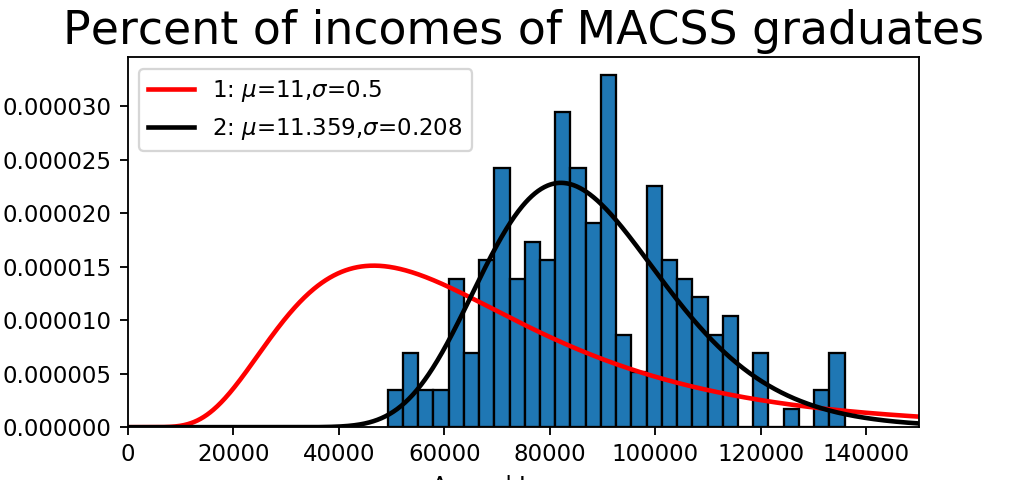

(0, 150000)

In [10]:
count, bins, ignored = plt.hist(inc, 30, edgecolor='black', normed=True)
plt.title('Percent of incomes of MACSS graduates', fontsize=20)
plt.xlabel('Annual Incomes')
plt.ylabel('Percent of Incomes')
plt.xlim([0, 150000])

### (b) Plot the lognormal PDF f(x|µ = 11.0, σ = 0.5) for 0 ≤ x ≤ 150, 000. What is the value of the log likelihood value for this parameterization of the distribution and given this data?

In [11]:
# plot
def truncnorm_pdf(xvals, mu, sigma, cutoff):
    '''
    Calculate log normal distribution.
    
    Inputs: xvals(numpy array)
            mu (float): mean
            sigma (float): standard deviation
            cutoff (float): scalar upper bound value of distribution,
                            or None
    Returns: pdf_vals(numpy array)
    '''
    
    if cutoff == 'None':
        prob_notcut = 1.0 - sts.norm.cdf(0, loc=mu, scale=sigma)
    else:
        prob_notcut = (sts.norm.cdf(cutoff, loc=mu, scale=sigma) -
                       sts.norm.cdf(0, loc=mu, scale=sigma))
            
    pdf_vals = ((1/(xvals * sigma * np.sqrt(2 * np.pi)) *
                np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2))) /
                prob_notcut)
    
    return pdf_vals

In [12]:
mu_1, sig_1= 11, 0.5
dist_inc = np.linspace(0.1, 150000, 1000)
plt.plot(dist_inc, truncnorm_pdf(dist_inc, mu_1, sig_1, 150000),
         linewidth=2, color='r', label='1: $\mu$=11,$\sigma$=0.5')
plt.legend(loc='upper left')

In [6]:
# get log likelihood value
def log_lik_truncnorm(xvals, mu, sigma, cutoff):
    pdf_vals = truncnorm_pdf(xvals, mu, sigma, cutoff)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

print('The Log-likelihood value is: ', log_lik_truncnorm(inc, mu_1, sig_1, 1000))

The Log-likelihood value is:  -2385.85699781


### (C) Estimate the parameters of the lognormal distribution by maximum likelihood and plot its PDF against the PDF from part (b) and the histogram from part (a). Plot the estimated PDF for 0 ≤ x ≤ 150, 000. Report the ML estimates for µ and σ, the value of the likelihood function, and the variance-covariance matrix.

In [36]:
# get MLE for µ and σ
def crit(params, *args):
    '''
    Computes the negative of the log likelihood function
    given parameters and data for minimization.
    
    Inputs: params(list): two floats, mu and sigma
            args(tuple): a numpy array, and the cutoff value
    Returns: neg_log_lik_val(float)
    '''
    mu, sigma = params
    xvals, cutoff = args
    log_lik_val = log_lik_truncnorm(xvals, mu, sigma, cutoff)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

params_init = np.array([mu_1, sig_1])
mle_args = (inc, 150000)
results = opt.minimize(crit, params_init, args=(mle_args), bounds = 
                       ((0.1, None), (0.1, None)))
mu_MLE, sig_MLE = results.x
print('the ML estimates for µ and σ are: mu_MLE=', mu_MLE, ' sig_MLE=', sig_MLE)

the ML estimates for µ and σ are: mu_MLE= 11.3590244332  sig_MLE= 0.208178546322


In [15]:
# plot
plt.plot(dist_inc, truncnorm_pdf(dist_inc, mu_MLE, sig_MLE, 150000),
         linewidth=2, color='k', label='2: $\mu$=11.359,$\sigma$=0.208')
plt.legend(loc='upper left')
plt.savefig('MLEplots.png')

In [21]:
# get log likelihood
print('The log likelihood using MLE is', log_lik_truncnorm(inc, mu_MLE, sig_MLE,1000))

The log likelihood using MLE is -2241.71930137


In [33]:
# get the variance-covariance matrix
OffDiagNeg = np.array([[1, -1], [-1, 1]])
vcv_mle = results.hess_inv.todense() * OffDiagNeg
stderr_mu_mle = np.sqrt(vcv_mle[0,0])
stderr_sig_mle = np.sqrt(vcv_mle[1,1])
print('VCV(MLE) = ', vcv_mle)
print('Standard error for mu estimate = ', stderr_mu_mle)
print('Standard error for sigma estimate = ', stderr_sig_mle)

VCV(MLE) =  [[  2.52847936e-04  -2.76193937e-05]
 [ -2.76193937e-05   1.30452099e-04]]
Standard error for mu estimate =  0.0159011929189
Standard error for sigma estimate =  0.0114215629173


### (d) Perform a likelihood ratio test to determine the probability that the data in incomes.txt came from the distribution in part (b).

In [28]:
log_lik_h0 = log_lik_truncnorm(inc, mu_1, sig_1, 1000)
log_lik_mle = log_lik_truncnorm(inc, mu_MLE, sig_MLE, 1000)
LR_val = 2 * (log_lik_mle - log_lik_h0)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 2)
print('chi squared of H0 with 2 degrees of freedom p-value = ', pval_h0, ', h0 is rejected')

chi squared of H0 with 2 degrees of freedom p-value =  0.0 ,h0 is rejected


### (e) With your estimated distribution of incomes for Chicago MACSS students from part (c), you now have a model for what your own income might look like when you graduate. Using that estimated model from part (c), What is the probability that you will earn more than 100,000? What is the probability that you will earn less than 75,000?

In [37]:
p_1 =  1 - sts.lognorm.cdf(100000, scale = np.exp(mu_MLE), s = sig_MLE)
p_2 = sts.lognorm.cdf(75000, scale = np.exp(mu_MLE), s = sig_MLE)
print("The probability that MACSS students will earn more than $100,000 is {:.2f} and \
the probability they earn less than $75,000 is {:.2f}.".format(p_1, p_2))

The probability that MACSS students will earn more than $100,000 is 0.23 and the probability they earn less than $75,000 is 0.26.


## Problem 2

### (a) Estimate (β0, β1, β2, β3, σ2) to maximize the likelihood of seeing the data in sick.txt. Report your estimates, the value of the log likelihood function, and the estimated variance covariance matrix of the estimates.

In [52]:
import pandas as pd
df_sick=  pd.read_csv('sick.txt')

In [55]:
# get error
#Calculate error term
def error_vals(sick, age, children, temp_winter, b0, b1, b2, b3):
    '''
    Calculate error terms.
    
    Inputs:
    sick: (N,) vector, values of number of weeks a baby being sick
    age: (N,) vector, values of the age of individual i at the end 
               of 2016
    children: how many children individual i had at the end of 2016
    temp_winter: (N,) vector, values of average temperature in winter
    b0: constant term
    b1: coefficient of age
    b2: coefficient of children
    b3: coefficient of temp_winter
    
    Returns: error value
    '''
    
    return sick - b0 - b1 * age - b2 * children - b3 * temp_winter

def crit(params,*args):
    '''
    Computes the negative of the log likelihood function
    given parameters and data for minimization.
    
    Inputs:
    arg:
        sick: (N,) vector, values of number of weeks a baby being sick
        age: (N,) vector, values of the age of individual i at the end 
                   of 2016
        children: how many children individual i had at the end of 2016
        temp_winter: (N,) vector, values of average temperature in winter
    parms:
        b0: constant term
        b1: coefficient of age
        b2: coefficient of children
        b3: coefficient of temp_winter
    
    Returns: negative log likelihood value
    '''
    age, children, winter, sick= args
    b0, b1, b2, b3, sigma = params
    n=len(age)
    log_lik_val = -n/2*np.log(2*np.pi)-n*np.log(sigma)-1/(2*sigma**2)*\
        np.sum(error_vals(sick, age, children, temp_winter, b0, b1, b2, b3)**2)
    return -log_lik_val

In [63]:
age = df_sick.age
children = df_sick.children
temp_winter = df_sick.avgtemp_winter
sick = df_sick.sick
params_init = (1,0,0,0,1)
results = opt.minimize(crit, params_init, args=((age, children, temp_winter, sick)),  \
                       method = 'L-BFGS-B',bounds=((0.1, None),\
                       (0.01, None), (0.1, None), (None, -0.001), (0.001, None)))
print ('The  are', results.x, 'for b0, b1, b2, b3 and sigma')
print ('The log likelihood is', crit(params_init,age, children, temp_winter,sick))

The  are [ 0.25164468  0.01293345  0.40050116 -0.0099917   0.00301767] for b0, b1, b2, b3 and sigma
The log likelihood is 209.092006641


In [65]:
OffDiagNeg = np.eye(5)*2-1
vcv =results.hess_inv.todense() * OffDiagNeg
stderr_mu_mle = np.sqrt(vcv_mle[0,0])
stderr_sig_mle = np.sqrt(vcv_mle[1,1])
print('VCV(MLE) = ', vcv)
print('Standard error for mu estimate = ', stderr_mu_mle)
print('Standard error for sigma estimate = ', stderr_sig_mle)

VCV(MLE) =  [[  1.01369774e+02   3.67937857e+00  -5.61263326e+01   8.11072922e-01
    1.52549681e+01]
 [  3.67937857e+00   1.33664268e-01   2.03793872e+00  -2.93933326e-02
   -5.53811000e-01]
 [ -5.61263326e+01   2.03793872e+00   3.10807991e+01   4.48779062e-01
    8.44705773e+00]
 [  8.11072922e-01  -2.93933326e-02   4.48779062e-01   6.50775025e-03
   -1.22014422e-01]
 [  1.52549681e+01  -5.53811000e-01   8.44705773e+00  -1.22014422e-01
    2.29579675e+00]]
Standard error for mu estimate =  0.0159011929189
Standard error for sigma estimate =  0.0114215629173


### (b) Use a likelihood ratio test to determine the probability that β0 = 1.0, σ2 = 0.01 and β1, β2, β3 = 0. That is, what is the likelihood that age, number of children, and average winter temperature have no eﬀect on the number of sick days?

In [70]:
params_h0 = np.array([1,0,0,0,0.1])
log_lik_h0 = -crit(params_h0, age, children, temp_winter, sick)
log_lik_mle = -crit(results.x, age, children, temp_winter, sick)
pval_h0 = 1.0 - sts.chi2.cdf(2 * (log_lik_mle - log_lik_h0), 5)
print('chi squared of H0 with 2 degrees of freedom p-value = ', pval_h0, ', h0 is rejected')

chi squared of H0 with 2 degrees of freedom p-value =  0.0 , h0 is rejected
